### Deteksi Missing Data

In [9]:
import pandas as pd
import numpy as np
import os

# 1. Load Data dengan path relatif
path_data = "../Data/Wind Data Stamet.csv"

# Gunakan parse_dates saat membaca agar format waktu langsung dikenali
df = pd.read_csv(path_data, parse_dates=['Timestamp'])

# Seringkali data BMKG punya timezone (+00:00), kita hilangkan agar mudah diolah
df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.tz_localize(None)

# Set sebagai index
df = df.set_index('Timestamp')

# 2. Filter Data 5 Tahun Terakhir (2019-2023)
# Menggunakan .loc pada index yang sudah berupa datetime
df = df.loc['2019-01-01':'2023-12-31'].copy()

# 3. Deteksi & Handling Missing Data
print("Jumlah nilai kosong sebelum interpolasi:\n", df.isnull().sum())

# Interpolasi untuk mengisi gap (penting untuk time series)
df = df.interpolate(method='linear')

# 4. Simpan hasil preprocessing ke folder Data untuk digunakan di Tahap 2
output_path = "../Data/Wind_Data_Cleaned.csv"
df.to_csv(output_path)

print("\nPreprocessing Selesai!")
print(f"Data disimpan di: {output_path}")
print(df.head())

Jumlah nilai kosong sebelum interpolasi:
 Wind Direction    0
Wind Speed        0
dtype: int64

Preprocessing Selesai!
Data disimpan di: ../Data/Wind_Data_Cleaned.csv
                     Wind Direction  Wind Speed
Timestamp                                      
2019-01-01 00:00:00           360.0         5.0
2019-01-01 01:00:00           350.0         5.0
2019-01-01 02:00:00           280.0         6.0
2019-01-01 03:00:00           330.0         7.0
2019-01-01 04:00:00           330.0         3.0


### Deteksi Outliers (Metode IQR)

Statistik Deskriptif:
- Q1: 2.00, Q3: 5.00, IQR: 3.00
- Batas Bawah: -2.50, Batas Atas: 9.50
- Jumlah baris terdeteksi outlier: 853


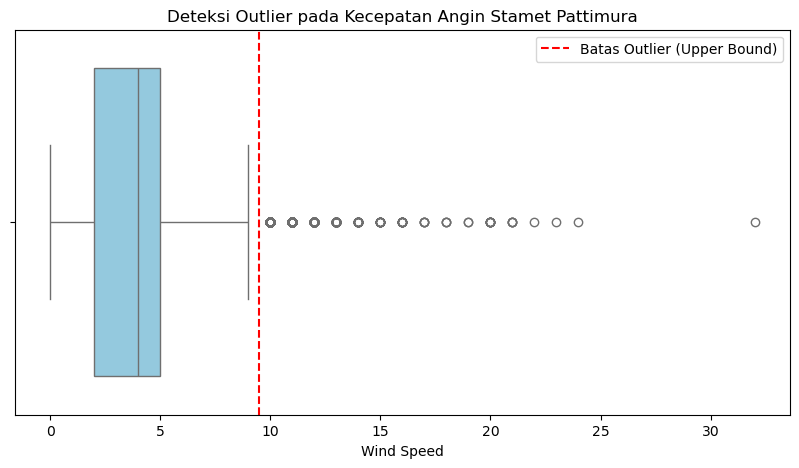

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 5. Deteksi Outliers (Metode IQR)
# Kita fokus pada 'Wind Speed' karena ini adalah Target Variable kita
Q1 = df['Wind Speed'].quantile(0.25)
Q3 = df['Wind Speed'].quantile(0.75)
IQR = Q3 - Q1

# Mendefinisikan batas (threshold)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Mengidentifikasi data yang berada di luar batas
outliers = df[(df['Wind Speed'] < lower_bound) | (df['Wind Speed'] > upper_bound)]

print(f"Statistik Deskriptif:")
print(f"- Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"- Batas Bawah: {lower_bound:.2f}, Batas Atas: {upper_bound:.2f}")
print(f"- Jumlah baris terdeteksi outlier: {len(outliers)}")

# Visualisasi dengan Boxplot untuk portofolio GitHub
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Wind Speed'], color='skyblue')
plt.savefig('../Data/boxplot_outlier.png') # Menyimpan Gambar
plt.axvline(upper_bound, color='red', linestyle='--', label='Batas Outlier (Upper Bound)')
plt.title('Deteksi Outlier pada Kecepatan Angin Stamet Pattimura')
plt.legend()
plt.show()

# Catatan Strategis:
# Dalam data cuaca, kita TIDAK menghapus outlier karena angin kencang (badai) 
# adalah informasi penting yang harus dipelajari model XGBoost/Random Forest.

### Visualisasi untuk melihat distribusi data

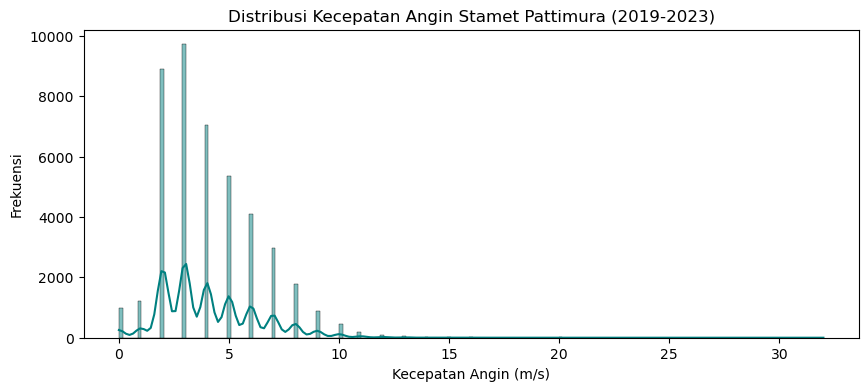

Cuplikan Data yang Siap Digunakan:
                     Wind Direction  Wind Speed
Timestamp                                      
2019-01-01 00:00:00           360.0         5.0
2019-01-01 01:00:00           350.0         5.0
2019-01-01 02:00:00           280.0         6.0
2019-01-01 03:00:00           330.0         7.0
2019-01-01 04:00:00           330.0         3.0


In [13]:
# 5. Visualisasi Distribusi (Penting untuk melihat kerapatan data)
plt.figure(figsize=(10, 4))
sns.histplot(df['Wind Speed'], kde=True, color='teal')
plt.savefig('../Data/histogram_distribusi.png') # Menyimpan Gambar
plt.title('Distribusi Kecepatan Angin Stamet Pattimura (2019-2023)')
plt.xlabel('Kecepatan Angin (m/s)')
plt.ylabel('Frekuensi')
plt.show()

# 6. Hasil Akhir & Simpan Data
print("Cuplikan Data yang Siap Digunakan:")
print(df.head())

# 📊 Laporan Tahap 1: Preprocessing & Analisis Data Eksploratif (EDA)
**Proyek:** Benchmarking Random Forest vs XGBoost - Prediksi Kecepatan Angin Per Jam (Stamet Pattimura Ambon)

## 1. Tujuan
Tahap ini bertujuan untuk menyiapkan data kecepatan dan arah angin dari Stamet Pattimura Ambon agar bersih, relevan, dan siap untuk digunakan dalam pemodelan Machine Learning. Proses ini mencakup pemilihan rentang waktu, penanganan data hilang, deteksi outlier, dan analisis distribusi data.

## 2. Seleksi Data
Data mentah yang tersedia mencakup periode 2014-2023. Untuk menjaga relevansi dengan pola cuaca terkini dan mengurangi beban komputasi, data difilter untuk periode **1 Januari 2019 hingga 31 Desember 2023** (5 tahun terakhir).

## 3. Pembersihan Data (Data Cleaning)
* **Penanganan Missing Values:**
    * Dilakukan pengecekan terhadap nilai-nilai yang hilang (`NaN`) pada setiap kolom.
    * Karena ini adalah data deret waktu (*time series*), missing values diisi menggunakan metode **Interpolasi Linear**. Metode ini efektif untuk mengisi celah pendek dengan estimasi berdasarkan nilai sebelumnya dan sesudahnya, sehingga menjaga kontinuitas pola waktu.
* **Format Waktu:** Kolom `Timestamp` telah berhasil diubah ke format `datetime` dan dijadikan sebagai indeks DataFrame, yang esensial untuk analisis deret waktu.

## 4. Deteksi dan Analisis Outlier
Deteksi outlier dilakukan pada kolom `Wind Speed` menggunakan metode **Interquartile Range (IQR)**:
* **Q1 (Kuartil Pertama):** 2.00 m/s
* **Q3 (Kuartil Ketiga):** 5.00 m/s
* **IQR (Interquartile Range):** 3.00 m/s
* **Batas Bawah Outlier:** -2.50 m/s (Secara fisik, kecepatan angin tidak mungkin negatif, sehingga nilai efektif minimum adalah 0 m/s).
* **Batas Atas Outlier:** 9.50 m/s

**Hasil:** Ditemukan **853 data** yang berada di atas batas atas (9.50 m/s), yang secara statistik dikategorikan sebagai outlier.

### Visualisasi Deteksi Outlier
Berikut adalah boxplot yang menunjukkan distribusi kecepatan angin dan batas outlier:
![Boxplot Outlier Kecepatan Angin](../Data/boxplot_outlier.png)

**Keputusan:** Data outlier **tidak dihapus**. Dalam konteks prediksi kecepatan angin, nilai-nilai ekstrem (seperti angin kencang/badai) merupakan kejadian fisik yang nyata dan sangat penting untuk dipelajari oleh model. Menghapusnya akan mengurangi kemampuan model untuk memprediksi kondisi cuaca kritis. Algoritma berbasis pohon seperti Random Forest dan XGBoost dikenal tangguh terhadap keberadaan outlier.

## 5. Analisis Distribusi Kecepatan Angin (Exploratory Data Analysis - EDA)
Distribusi kecepatan angin selama 5 tahun terakhir divisualisasikan menggunakan histogram dengan estimasi kerapatan kernel (KDE).

### Visualisasi Distribusi Kecepatan Angin
![Histogram Distribusi Kecepatan Angin](../Data/histogram_distribusi.png)

**Temuan:**
* **Distribusi Miring Kanan (Right-Skewed):** Mayoritas data kecepatan angin berada pada rentang rendah hingga sedang (sekitar 2-5 m/s), dengan frekuensi yang menurun secara signifikan seiring peningkatan kecepatan angin. Ini menunjukkan bahwa kondisi angin relatif tenang lebih sering terjadi di Ambon dibandingkan kondisi angin kencang.
* **Pola Diskrit:** Terlihat adanya paku-paku pada histogram yang menunjukkan preferensi pada pembulatan angka (misalnya, angka bulat lebih sering muncul dibandingkan desimal). Ini adalah karakteristik umum data pengukuran dari sensor.

## 6. Kesimpulan Tahap 1
Data kecepatan dan arah angin dari Stamet Pattimura Ambon untuk periode 2019-2023 telah berhasil diproses. Data kini bersih dari missing values, memiliki format yang konsisten, dan karakteristik distribusinya telah dianalisis. Keberadaan outlier telah diidentifikasi dan diputuskan untuk dipertahankan, yang sejalan dengan pemilihan model Random Forest dan XGBoost. Data sudah siap untuk tahap selanjutnya yaitu Rekayasa Fitur (*Feature Engineering*).